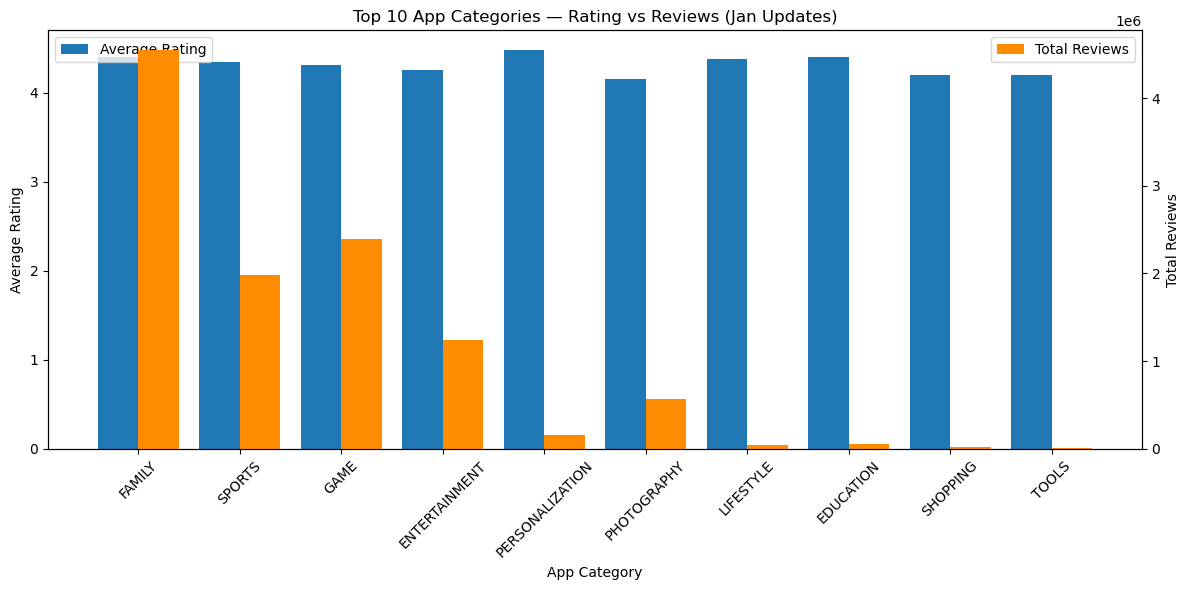

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

df = pd.read_csv("Play Store Data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_")

df['Last_Updated'] = pd.to_datetime(df['Last_Updated'], errors='coerce')

def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(convert_size)

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df = df.dropna(subset=['Category','Rating','Reviews','Installs','Size_MB','Last_Updated'])

filtered_df = df[
    (df['Rating'] >= 4.0) &
    (df['Size_MB'] >= 10) &
    (df['Last_Updated'].dt.month == 1)
]

top_categories = (
    filtered_df
    .groupby('Category', as_index=False)
    .agg({
        'Installs': 'sum',
        'Rating': 'mean',
        'Reviews': 'sum'
    })
    .sort_values(by='Installs', ascending=False)
    .head(10)
)

# -------- TIME CHECK --------
ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist)

start = now.replace(hour=0, minute=0, second=0, microsecond=0)
end = now.replace(hour=23, minute=0, second=0, microsecond=0)

if start <= now <= end:

    x = range(len(top_categories))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()   # second Y axis

    # Rating bars (left axis)
    ax1.bar(
        x,
        top_categories['Rating'],
        width=width,
        label='Average Rating'
    )

    # Reviews bars (right axis)
    ax2.bar(
        [i + width for i in x],
        top_categories['Reviews'],
        width=width,
        label='Total Reviews',
        color='darkorange'
    )

    ax1.set_xlabel("App Category")
    ax1.set_ylabel("Average Rating")
    ax2.set_ylabel("Total Reviews")

    ax1.set_xticks([i + width/2 for i in x])
    ax1.set_xticklabels(top_categories['Category'], rotation=45)

    ax1.set_title("Top 10 App Categories — Rating vs Reviews (Jan Updates)")

    # Legends
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

else:
    print("⏰ Chart visible only between 3 PM and 5 PM IST")

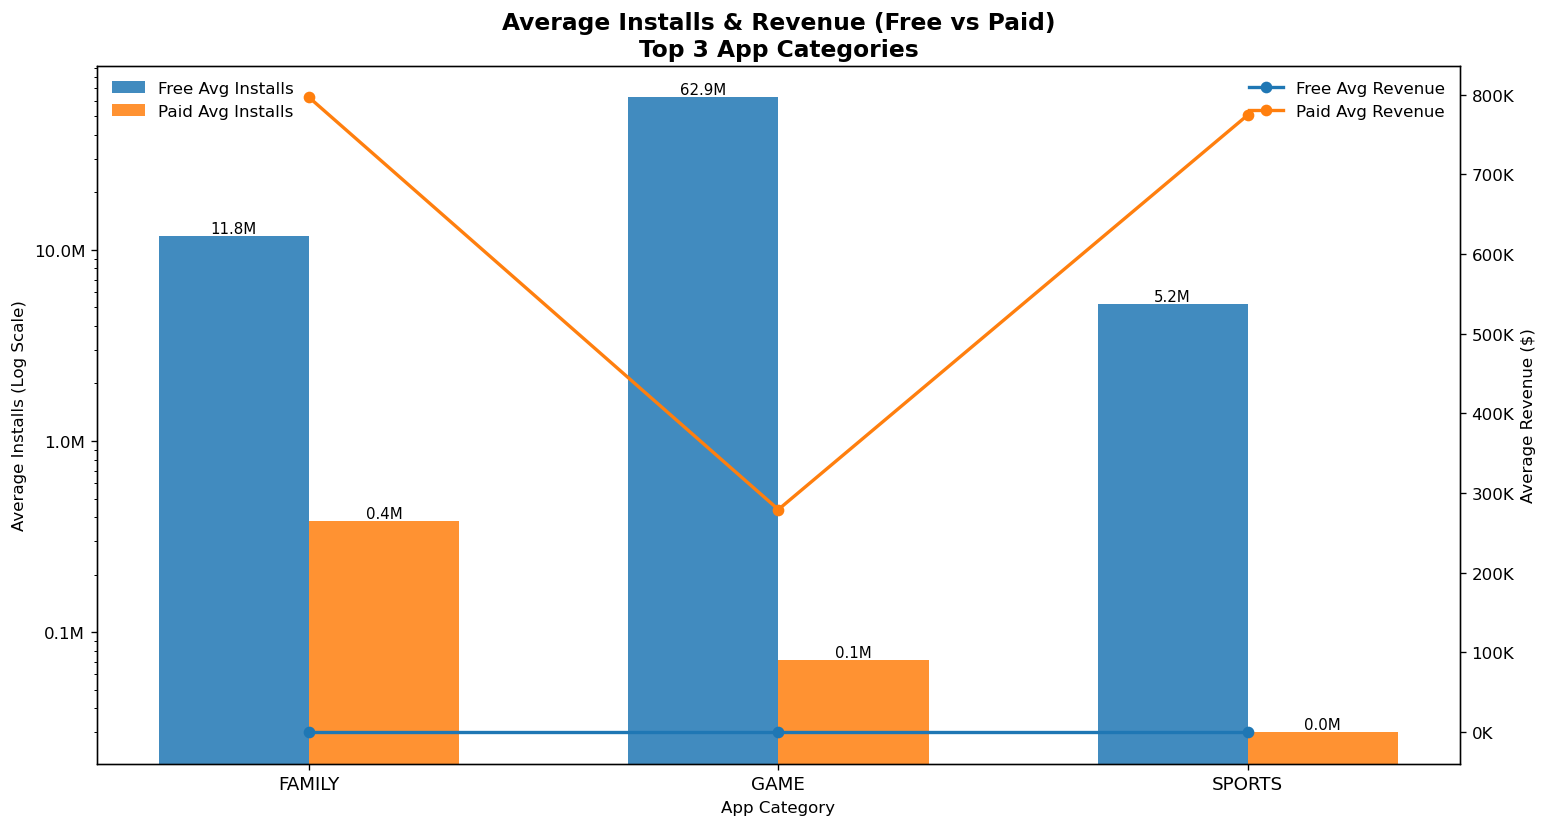

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
from matplotlib.ticker import FuncFormatter

df = pd.read_csv("Play Store Data.csv")

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df['Revenue'] = df['Price'] * df['Installs']
df.loc[df['Type'] == 'Free', 'Revenue'] = 0

def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M',''))
        elif 'k' in size:
            return float(size.replace('k','')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(clean_size)

df['Android_Ver_Clean'] = df['Android Ver'].astype(str).str.extract(r'(\d+\.\d+)')
df['Android_Ver_Clean'] = pd.to_numeric(df['Android_Ver_Clean'], errors='coerce')

df['App_Length'] = df['App'].astype(str).str.len()

filtered_df = df[
    (df['Installs'] >= 10000) &
    (df['Android_Ver_Clean'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == 'Everyone') &
    (df['App_Length'] <= 30)
]

filtered_df = filtered_df[
    (filtered_df['Type'] == 'Free') |
    ((filtered_df['Type'] == 'Paid') & (filtered_df['Revenue'] >= 10000))
]

top_categories = filtered_df['Category'].value_counts().head(3).index
top_df = filtered_df[filtered_df['Category'].isin(top_categories)]

grouped = (
    top_df
    .groupby(['Category','Type'])
    .agg({'Installs':'mean','Revenue':'mean'})
    .reset_index()
)

pivot_installs = grouped.pivot(index='Category', columns='Type', values='Installs').fillna(0)
pivot_revenue  = grouped.pivot(index='Category', columns='Type', values='Revenue').fillna(0)

for col in ['Free','Paid']:
    if col not in pivot_installs:
        pivot_installs[col] = 0
    if col not in pivot_revenue:
        pivot_revenue[col] = 0

categories = pivot_installs.index
x = range(len(categories))
width = 0.32

manual_time = "13:30"  
user_time = datetime.strptime(manual_time, "%H:%M").time()

start_time = time(13, 0)
end_time   = time(14, 0)

def millions(x, pos):
    return f'{x/1_000_000:.1f}M'

def thousands(x, pos):
    return f'{x/1_000:.0f}K'

if start_time <= user_time <= end_time:

    fig, ax1 = plt.subplots(figsize=(13,7), dpi=120)
    ax2 = ax1.twinx()

    # Bars
    free_bars = ax1.bar(
        [i - width/2 for i in x],
        pivot_installs['Free'],
        width=width,
        label='Free Avg Installs',
        alpha=0.85
    )

    paid_bars = ax1.bar(
        [i + width/2 for i in x],
        pivot_installs['Paid'],
        width=width,
        label='Paid Avg Installs',
        alpha=0.85
    )


    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions))
    ax1.set_ylabel("Average Installs (Log Scale)")

    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=11)
    ax1.set_xlabel("App Category")

    ax2.plot(x, pivot_revenue['Free'], marker='o', linewidth=2, label='Free Avg Revenue')
    ax2.plot(x, pivot_revenue['Paid'], marker='o', linewidth=2, label='Paid Avg Revenue')
    ax2.yaxis.set_major_formatter(FuncFormatter(thousands))
    ax2.set_ylabel("Average Revenue ($)")

    for bar in free_bars + paid_bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{height/1_000_000:.1f}M',
                ha='center',
                va='bottom',
                fontsize=9
            )

    ax1.legend(loc='upper left', frameon=False)
    ax2.legend(loc='upper right', frameon=False)

    plt.title(
        "Average Installs & Revenue (Free vs Paid)\nTop 3 App Categories",
        fontsize=14,
        weight='bold'
    )

    plt.tight_layout()
    plt.show()

else:
    print("⏰ Chart visible only between 1 PM – 2 PM IST")

In [8]:
import pandas as pd
import plotly.express as px
from datetime import datetime
import pytz
import random

# ---------------- LOAD DATA ----------------
df = pd.read_csv("Play Store Data.csv")

# ---------------- CLEAN INSTALLS ----------------
df['Installs'] = df['Installs'].astype(str)\
    .str.replace(',', '', regex=False)\
    .str.replace('+', '', regex=False)

df = df[df['Installs'].str.isnumeric()]
df['Installs'] = df['Installs'].astype(int)

# ---------------- TOTAL INSTALLS BY CATEGORY ----------------
category_installs = df.groupby('Category', as_index=False)['Installs'].sum()

# ---------------- REMOVE A C G S ----------------
category_installs = category_installs[
    ~category_installs['Category'].str.startswith(('A','C','G','S'))
]

# ---------------- TOP 5 ----------------
top5 = category_installs.nlargest(5, 'Installs')['Category']
df_top5 = df[df['Category'].isin(top5)].copy()

# ---------------- ADD DEMO COUNTRIES ----------------
countries = ['India','USA','UK','Canada','Germany','France','Brazil','Australia']
df_top5['Country'] = [random.choice(countries) for _ in range(len(df_top5))]

# ---------------- HIGHLIGHT ----------------
df_top5['Highlight'] = df_top5['Installs'].apply(
    lambda x: 'Above 1M' if x > 1_000_000 else 'Below 1M'
)

# ---------------- CREATE CHOROPLETH DATA ----------------
choropleth_df = (
    df_top5
    .groupby(['Country','Category','Highlight'], as_index=False)['Installs']
    .sum()
)

# ---------------- TIME CHECK ----------------
ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist)

start = now.replace(hour=0, minute=0, second=0, microsecond=0)
end   = now.replace(hour=23, minute=0, second=0)

# ---------------- SHOW MAP ----------------
if start <= now <= end:

    fig = px.choropleth(
        choropleth_df,
        locations="Country",
        locationmode="country names",
        color="Installs",
        hover_name="Category",
        hover_data=["Highlight"],
        animation_frame="Category",
        color_continuous_scale="Viridis",
        title="Global Installs by Top 5 App Categories"
    )

    fig.show()

else:
    print("⏰ Choropleth visible only between 6 PM and 8 PM IST")

C:\Users\nabin\AppData\Local\Temp\ipykernel_2004\2414548680.py:56: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


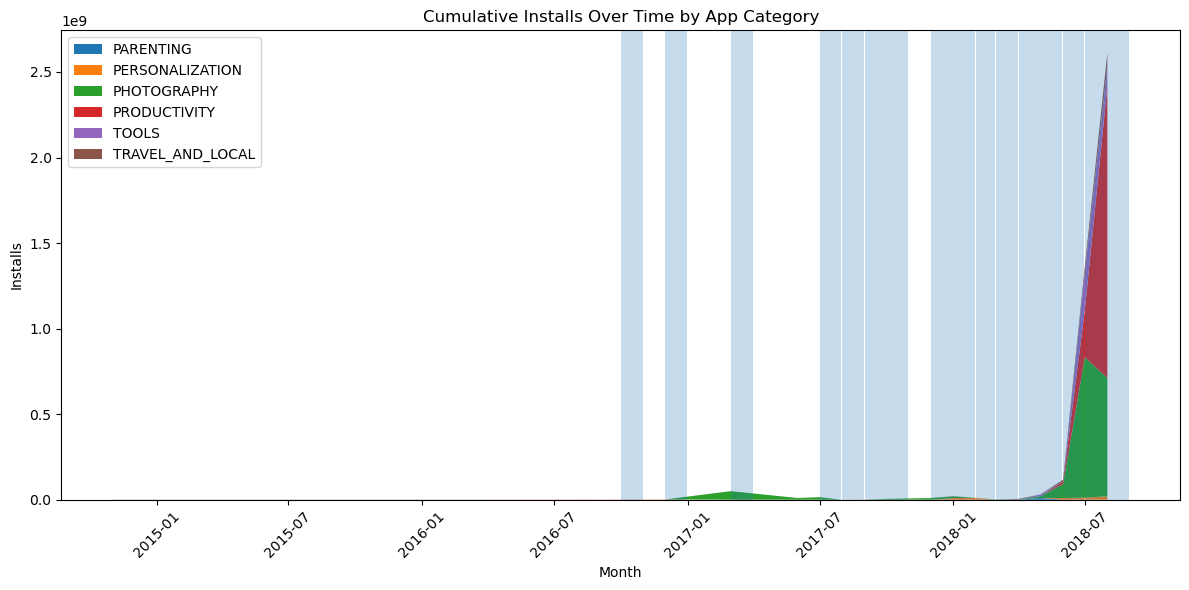

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import re

# ---------------- LOAD DATA ----------------
df = pd.read_csv('Play Store Data.csv')

# ---------------- CLEAN ----------------
df_clean = df.dropna(subset=['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs']).copy()

df_clean['Reviews'] = pd.to_numeric(df_clean['Reviews'], errors='coerce')
df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')

# ---- Size to MB ----
def size_to_mb(size):
    size = str(size)
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024
    return np.nan

df_clean['Size_MB'] = df_clean['Size'].apply(size_to_mb)

# ---- Clean installs ----
df_clean['Installs'] = (
    df_clean['Installs']
    .astype(str)
    .str.replace('+','', regex=False)
    .str.replace(',','', regex=False)
)

df_clean['Installs'] = pd.to_numeric(df_clean['Installs'], errors='coerce')

# ---------------- APPLY REQUIRED FILTERS ----------------

df_filtered = df_clean.loc[
    (df_clean['Rating'] >= 4.2) &
    (df_clean['Reviews'] > 1000) &
    (df_clean['Size_MB'].between(20, 80)) &
    (df_clean['Category'].str.startswith(('T','P'), na=False)) &
    (~df_clean['App'].str.contains(r'\d', regex=True))   # ❗ no numbers in app name
].copy()

# ---------------- TRANSLATE LEGEND ----------------

translation_map = {
    'Travel & Local': 'Voyage & Local',
    'Productivity': 'Productividad',
    'Photography': '写真'
}

df_filtered['Category_Translated'] = (
    df_filtered['Category']
    .map(translation_map)
    .fillna(df_filtered['Category'])
)

# ---------------- DATE HANDLING ----------------

df_filtered['Last Updated'] = pd.to_datetime(
    df_filtered['Last Updated'],
    format='%B %d, %Y',
    errors='coerce'
)

df_filtered = df_filtered[df_filtered['Last Updated'].notna()].copy()

df_filtered['Month'] = df_filtered['Last Updated'].dt.to_period('M')

# ---------------- MONTHLY CUMULATIVE DATA ----------------

monthly_installs = (
    df_filtered
    .groupby(['Month','Category_Translated'])['Installs']
    .sum()
    .unstack(fill_value=0)
)

# ---------------- GROWTH HIGHLIGHT ----------------

growth = monthly_installs.pct_change()
highlight_months = growth.gt(0.25).any(axis=1)

# ---------------- TIME WINDOW (4 PM – 6 PM IST) ----------------

ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist)

start = now.replace(hour=0, minute=0, second=0, microsecond=0)
end   = now.replace(hour=23, minute=0, second=0, microsecond=0)

# ---------------- PLOT ----------------

if start <= now <= end and not monthly_installs.empty:

    plot_df = monthly_installs.copy()
    plot_df.index = plot_df.index.to_timestamp()

    fig, ax = plt.subplots(figsize=(12,6))

    ax.stackplot(
        plot_df.index,
        plot_df.T.values,
        labels=plot_df.columns
    )

    # 🔥 Highlight months where growth > 25%
    for month, flag in zip(plot_df.index, highlight_months):
        if flag:
            ax.axvspan(month, month + pd.offsets.MonthEnd(1), alpha=0.25)

    ax.set_title("Cumulative Installs Over Time by App Category")
    ax.set_xlabel("Month")
    ax.set_ylabel("Installs")
    ax.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("⏰ Chart visible only between 4 PM and 6 PM IST (or no data after filters)")

Graph visible only between 5 PM and 7 PM IST


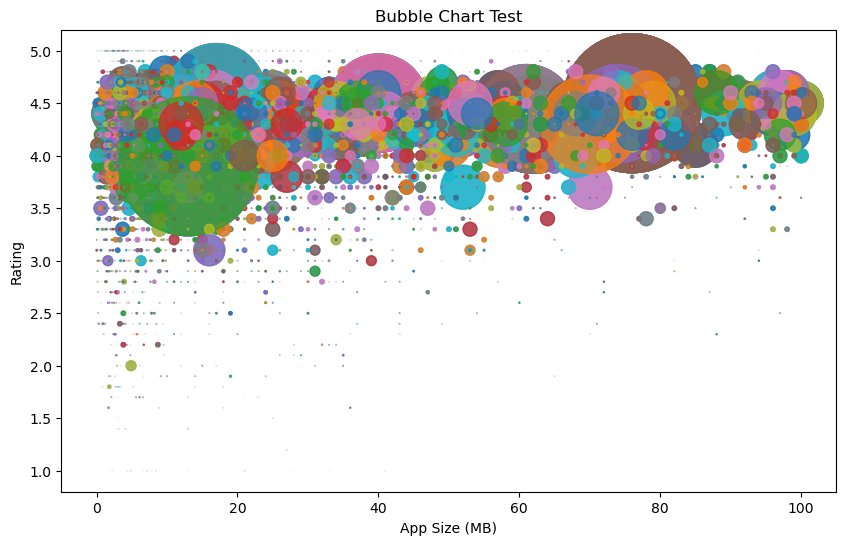

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz

df = pd.read_csv("Play Store Data.csv")

# Clean columns
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

def convert_size(size):
    if 'M' in str(size):
        return float(size.replace('M',''))
    elif 'k' in str(size):
        return float(size.replace('k','')) / 1024
    else:
        return None

df['Size_MB'] = df['Size'].apply(convert_size)

# Drop empty rows
df = df.dropna(subset=['Size_MB','Rating','Installs'])


# ---- BASIC BUBBLE CHART ----
plt.figure(figsize=(10,6))

plt.scatter(
    df['Size_MB'],
    df['Rating'],
    s=df['Installs'] / 100000,   # big visible bubbles
    alpha=0.6
)

plt.xlabel("App Size (MB)")
plt.ylabel("Rating")
plt.title("Bubble Chart Test")

# ----- TIME FILTER (5 PM to 7 PM IST) -----
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.datetime.now(ist).time()

start_time = datetime.time(17, 0)   # 5 PM
end_time = datetime.time(19, 0)     # 7 PM

if not (start_time <= current_time <= end_time):
    print("Graph visible only between 5 PM and 7 PM IST")
    exit()

# ----- COLORFUL BUBBLES -----
colors = np.random.rand(len(df))

plt.scatter(
    df['Size_MB'],
    df['Rating'],
    s=df['Installs'] / 100000,
    c=colors,
    cmap='tab10',
    alpha=0.7
)


plt.show()

In [11]:
import pandas as pd
import plotly.express as px
from datetime import datetime, time

def show_installs_time_series(df, input_time_ist):

    user_time = datetime.strptime(input_time_ist, "%H:%M").time()
    start_time = time(0, 0)
    end_time = time(23, 0)

    if not (start_time <= user_time <= end_time):
        print("⚠️ Warning: This chart is available only between 6 PM and 9 PM IST.")
        return

    df = df.copy()

    def clean_installs(val):
        try:
            return int(float(str(val).replace(",", "").replace("+", "")))
        except:
            return None

    df["Installs_Clean"] = df["Installs"].apply(clean_installs)
    df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")
    df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors="coerce")

    df = df.dropna(subset=["Installs_Clean", "Last Updated", "Reviews"])

    df = df[
        (df["Reviews"] > 500) &
        (~df["App"].astype(str).str.upper().str.startswith(("X", "Y", "Z"))) &
        (~df["App"].astype(str).str.contains("S", case=False)) &
        (df["Category"].astype(str).str.upper().str.startswith(("E", "C", "B")))
    ]

    if df.empty:
        print("⚠️ Warning: Time condition satisfied, but no data matches the filters.")
        return

    category_translation = {
        "BEAUTY": "सौंदर्य",
        "BUSINESS": "வணிகம்",
        "DATING": "Partnersuche"
    }

    df["Category_Display"] = df["Category"].str.upper().replace(category_translation)
    df["Month"] = df["Last Updated"].dt.to_period("M").dt.to_timestamp()

    grouped = (
        df.groupby(["Month", "Category_Display"])["Installs_Clean"]
        .sum()
        .reset_index()
        .sort_values("Month")
    )

    fig = px.line(
        grouped,
        x="Month",
        y="Installs_Clean",
        color="Category_Display",
        title="Total Installs Trend Over Time by Category"
    )

    fig.update_layout(
        xaxis_title="Month",
        yaxis_title="Total Installs",
        template="plotly_white"
    )

    fig.show()


# ✅ CALL IT OUTSIDE THE FUNCTION
show_installs_time_series(df, "18:00")
